<a href="https://colab.research.google.com/github/Mathieu-Putz/Playing-with-PINNs/blob/main/2_Second_order_ODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
import numpy as np  
import sympy as sy
from mpl_toolkits import mplot3d
from matplotlib import cm
from matplotlib.ticker import LinearLocator

# 2. Slightly more complicated: A second order ODE

Let's try our hand at the following classical oscillation problem:

y'' + y' + y = 0

y(t=0) = 1

y'(t=0) = 0

Here too, the exact analytical solution is known, which we can again use as ground truth. The parameters are chosen such that the system is underdamped, i.e. we should get an oscillating wave whose amplitude declines within an exponential envelope. It takes the following form:

y(t) = exp(-0.5*t) * 2A* cos( phi + t) 

where A = sqrt(5)/4 and phi = 2*Arctan( 2-sqrt(5) ) + 2*pi*n (let's choose n=0)

Note: technically there's a second solution with a negative amplitude A, which we'll ignore here.

The analytical expressions for the constants A and phi are quite involved.

We now have two different boundary conditions and need to regularize for both.



In [2]:
time_points = torch.rand((100))*10
time_points, _ = torch.sort(time_points)

A = np.sqrt(5) /4 
phi = 2*np.arctan(2-np.sqrt(5))

datapoints = torch.exp(-0.5*time_points)*2*A*torch.cos(phi+time_points)

# In this example the two boundaries, 
#  one for the value at a given point, 
#  the other for the derivative at a given point, 
# happen to coincide, but in principle, they could be different. 
boundary1 = torch.tensor([0.0])
boundary2 = torch.tensor([0.0])

boundary1_values = torch.tensor([1.0])
boundary2_derivatives = torch.tensor([0.0]) 


In [3]:
# Define the Neural Network:
model = nn.Sequential(nn.Linear(1, 50), nn.ReLU(), nn.Linear(50,1))
learning_rate = 1e-3

# Loss function modified to take 2nd boundary condition into account.
# add lambda parameters for weight of different losses
def loss(time_points, boundary1, boundary2, datapoints, boundary1_values, boundary2_derivatives):  #last three arguments represent ground truth
  y_pred = model(time_points)
  y_pred_boundary1  = model(boundary1)
  # How to get derivative of prediction?
  # Approximate using two points that are very close to boundary2 point.
  epsilon = 0.001
  dy_pred_boundary2 = ( model(boundary2+epsilon) - model(boundary2 - epsilon) ) / (2*epsilon)  
  return torch.mean((y_pred - datapoints)**2) + 1* torch.mean((y_pred_boundary1 - boundary1_values)**2) + 1* torch.mean((dy_pred_boundary2-boundary2_derivatives)**2)

# Optimize
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# Run the optimizer
def closure():
    optimizer.zero_grad()
    # In retrospect, I'm not sure adding [:,None] to each variable was necessary or whether it even made sense.
    # Rather than trying to find out, I'm happy to notice that it worked well enough and move on to more interesting examples.
    l = loss(time_points[:,None], boundary1[:,None], boundary2[:,None], 
              datapoints[:,None], boundary1_values[:,None], boundary2_derivatives)
    l.backward()
    return l
#print(loss(time_points[:,None], boundary_points[:,None], datapoints[:,None], boundary_values[:,None]))

for i in range(100000):
    optimizer.step(closure)
    # to observe the loss with number of iterations, uncomment following two lines:
    #if i%300 ==299:
    #  print(loss(time_points[:,None], boundary_points[:,None], datapoints[:,None], boundary_values[:,None]))

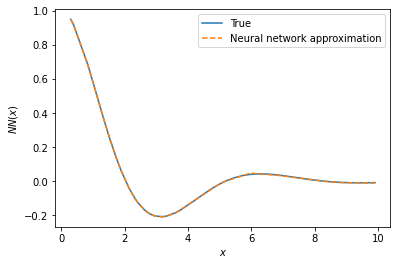

In [4]:
# Let's compare the result to the true solution
time_points_np = time_points.numpy()
datapoints_np = datapoints.numpy()
y_pred_np     = model(time_points[:,None]).detach().numpy()



fig, ax = plt.subplots()
ax.plot(time_points_np, datapoints_np, label='True')
ax.plot(time_points_np, y_pred_np, '--', label='Neural network approximation')
ax.set_xlabel('$x$')
ax.set_ylabel('$NN(x)$')
plt.legend(loc='best')

The solution is visibly imperfect, but basically fits the curve, so I'll count this as a success. Again, there is a lot of room for improvement here, again all the hyperparameters were chosen arbitrarily, but I think this is good enough as a proof of concept. 

Let's move on to a PDE then!